# NR Classification

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

import sys
import random as rd
import torch
from torch import nn, optim
import torch.nn.functional as F
import torch.utils.data as tud
# from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

import CustomDataset as cd

### Loading Data

First, I'm going to try to distinguish between Carbon 130keV and Flourine 170keV.

In [8]:
C130_dat, F170_dat = np.load('data/C_130keV_10000.npy'), np.load('data/F_170keV_10000.npy')

In [9]:
data, labels = [],[]
Csum, Fsum = [],[]

for i in range(len(C130_dat)):
    data.append(C130_dat[i])
    labels.append(0)
    Csum.append(np.sum(C130_dat[i]))

for i in range(len(F170_dat)):
    data.append(F170_dat[i])
    labels.append(1)
    Fsum.append(np.sum(F170_dat[i]))


Accuracy Possible with Cut of 2096 on Total Intensity: 93.67%


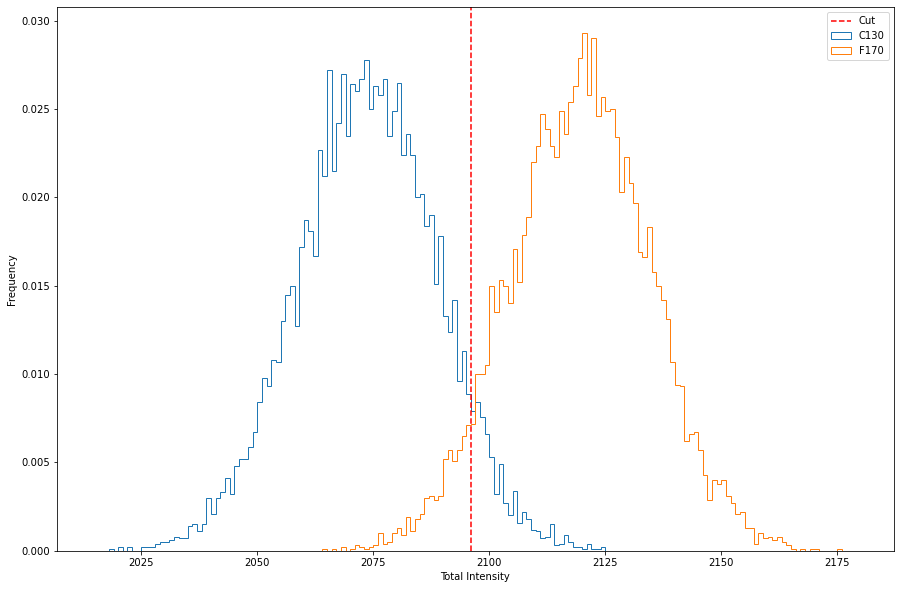

In [10]:
cut = 2096
Cless, Fgrt = [],[]
for i in range(len(Fsum)):
    if Fsum[i] > cut:
        Fgrt.append(Fsum[i])
    if Csum[i] <= cut:
        Cless.append(Csum[i])

plt.figure(figsize=(15,10))
plt.hist(Csum, density=True, histtype='step', bins=np.arange(2015,2180,1), label='C130')  # density=False would make counts
plt.hist(Fsum, density=True, histtype='step', bins=np.arange(2015,2180,1), label='F170')
plt.axvline(cut, c='r', ls='--', label='Cut')
plt.ylabel('Frequency')
plt.xlabel('Total Intensity')
plt.legend()
plt.savefig('intensity_hist.png')

Acc = (len(Fgrt)+len(Cless))/(len(Fsum)+len(Csum))*100
print('\nAccuracy Possible with Cut of {} on Total Intensity: {}%'.format(cut,Acc))

In [11]:
np.random.seed(10) #fixes random seed to 10 for reproducible results
p = np.random.permutation(len(data)) #performs random permutation to get shuffled indices
data = np.array(data)[p] #applies shuffled indices to X data
labels = np.array(labels)[p] #applies shuffled indices to y data

In [12]:
#Reducing data for testing model stability

In [13]:
# red_size = 3000
# data = data[:red_size]
# labels = labels[:red_size]

In [14]:
data.shape

(20000, 97, 97)

In [15]:
np.mean(data)

0.2227727494951642

In [16]:
# data_norm = data/np.max(data)
data_norm = (data - np.nanmean(data,axis=0))/np.nanstd(data,axis=0)
data_norm[data_norm!=data_norm]=0

/tmp/ipykernel_15604/2423433199.py:2: RuntimeWarning: invalid value encountered in true_divide
  data_norm = (data - np.nanmean(data,axis=0))/np.nanstd(data,axis=0)


In [17]:
BATCH_SIZE=100

In [18]:
X_train, X_test, y_train, y_test = train_test_split(data_norm, labels, test_size=0.3, random_state=42)

xtrain_tensor = torch.from_numpy(np.array(X_train)) #converts numpy array to torch tensor
xtrain_sqz = xtrain_tensor.unsqueeze(1) #adds new dimension along axis 1
print(xtrain_sqz.shape)

ytrain_tensor = torch.from_numpy(np.array(y_train))
print(ytrain_tensor.shape)

xtest_tensor = torch.from_numpy(np.array(X_test)) #converts numpy array to torch tensor
xtest_sqz = xtest_tensor.unsqueeze(1) #adds new dimension along axis 1
print(xtest_sqz.shape)

ytest_tensor = torch.from_numpy(np.array(y_test))
print(ytest_tensor.shape)

train_data = cd.CustomDataset(xtrain_sqz.float(), ytrain_tensor.float())
test_data = cd.CustomDataset(xtest_sqz.float(), ytest_tensor.float())

#defining dataloader class
train_loader = tud.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)

#same as above but for test data
test_loader = tud.DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=True)

torch.Size([14000, 1, 97, 97])
torch.Size([14000])
torch.Size([6000, 1, 97, 97])
torch.Size([6000])


In [19]:
# for i, (images, labels) in enumerate(test_loader):
# #     print(images[0])
# #     plt.matshow(images[i].squeeze(0))
#     print(labels)
#     print(len(labels[labels==0]))
#     print(len(labels[labels==1]))

In [20]:
# for i, (images, labels) in enumerate(test_loader):
#     print(labels)
#     break

In [21]:
# Model


# class Model1(nn.Module):
#     def __init__(self):
#         super(Model1, self).__init__()

#         self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)
#         self.d1 = nn.Linear(95 * 95 * 32, 128)
#         self.d2 = nn.Linear(128, 2)

#     def forward(self, x):
#         x = self.conv1(x)
#         x = F.relu(x)

#         x = x.flatten(start_dim = 1)

#         x = self.d1(x)
#         x = F.relu(x)

#         logits = self.d2(x)
#         out = F.softmax(logits, dim=1)
#         return out


# class Model2(nn.Module):
#     def __init__(self):
#         super(Model2, self).__init__()

#         self.d1 = nn.Linear(97 * 97, 1024)
#         self.d2 = nn.Linear(1024, 1024)
#         self.d3 = nn.Linear(1024, 2)

#     def forward(self, x):

#         x = x.flatten(start_dim = 1)

#         x = self.d1(x)
#         x = F.relu(x)

#         x = self.d2(x)
#         x = F.relu(x)

#         logits = self.d3(x)

#         out = F.softmax(logits, dim=1)

#         return out


class Model2(nn.Module):
    def __init__(self):
        super(Model2, self).__init__()

        self.d1 = nn.Linear(97 * 97, 2)

    def forward(self, x):

        x = x.flatten(start_dim = 1)

        logits = self.d1(x)

        out = F.softmax(logits, dim=1)


        return out


In [22]:
device = torch.device('cpu')

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
            
        self.fc_layers = nn.Sequential(
            nn.Linear(97*97,1),
            nn.ELU(),
            nn.Flatten(0,1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.flatten(start_dim = 1)
        x = self.fc_layers(x)
        return x

In [23]:
# Accuracy

def get_accuracy(logit, target, BATCH_SIZE):
    ''' Obtain accuracy for training round '''
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects/BATCH_SIZE
    return accuracy.item()

In [24]:
# Training set up

learning_rate = 0.01
num_epochs = 500

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = Model2() 
model = model.to(device)
# criterion = nn.BCELoss()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [25]:
# Training


for epoch in range(num_epochs):
    train_running_loss = 0.0
    train_acc = 0.0

    model = model.train()

    ## training step
    for i, (images, labels) in enumerate(train_loader):

        labels=labels.type(torch.LongTensor)
        
        images = images.to(device)
        labels = labels.to(device)

        ## forward + backprop + loss
        logits = model(images)
        loss = criterion(logits, labels)
        optimizer.zero_grad()
        loss.backward()

        ## update model params
        optimizer.step()

        train_running_loss += loss.detach().item()
        train_acc += get_accuracy(logits, labels, BATCH_SIZE)
    
    model.eval()
    print('Epoch: %d | Loss: %.4f | Train Accuracy: %.2f' \
          %(epoch, train_running_loss / i, train_acc/i))     
    
    test_acc = 0.0
    for i, (images, labels) in enumerate(test_loader, 0):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        test_acc += get_accuracy(outputs, labels, BATCH_SIZE)
    
    print('Test Accuracy: %.2f'%( test_acc/i))

Epoch: 0 | Loss: 0.7197 | Train Accuracy: 57.27
Test Accuracy: 60.54
Epoch: 1 | Loss: 0.7004 | Train Accuracy: 60.17
Test Accuracy: 60.46
Epoch: 2 | Loss: 0.6866 | Train Accuracy: 62.00
Test Accuracy: 60.17
Epoch: 3 | Loss: 0.6855 | Train Accuracy: 62.19
Test Accuracy: 59.64
Epoch: 4 | Loss: 0.6760 | Train Accuracy: 63.33
Test Accuracy: 59.95
Epoch: 5 | Loss: 0.6727 | Train Accuracy: 63.76
Test Accuracy: 60.69
Epoch: 6 | Loss: 0.6667 | Train Accuracy: 64.40
Test Accuracy: 61.66
Epoch: 7 | Loss: 0.6615 | Train Accuracy: 65.11
Test Accuracy: 61.08
Epoch: 8 | Loss: 0.6583 | Train Accuracy: 65.42
Test Accuracy: 61.20
Epoch: 9 | Loss: 0.6567 | Train Accuracy: 65.50
Test Accuracy: 60.54
Epoch: 10 | Loss: 0.6554 | Train Accuracy: 65.77
Test Accuracy: 61.29
Epoch: 11 | Loss: 0.6492 | Train Accuracy: 66.43
Test Accuracy: 60.98
Epoch: 12 | Loss: 0.6481 | Train Accuracy: 66.51
Test Accuracy: 61.51
Epoch: 13 | Loss: 0.6411 | Train Accuracy: 67.35
Test Accuracy: 61.08
Epoch: 14 | Loss: 0.6421 | Tra

In [26]:
test_acc = 0.0
for i, (images, labels) in enumerate(test_loader, 0):
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    
    test_acc += get_accuracy(outputs, labels, BATCH_SIZE)
        
print('Test Accuracy: %.2f'%( test_acc/i))

Test Accuracy: 88.68


In [27]:
for i, (images, labels) in enumerate(test_loader, 0):
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    
pre_cor = (torch.max(outputs, 1)[1].view(labels.size()).data == labels.data)
corrects = (torch.max(outputs, 1)[1].view(labels.size()).data == labels.data).sum()
accuracy = 100.0 * corrects/BATCH_SIZE

In [30]:
print(labels[0])

tensor(0., device='cuda:0')


In [22]:
pre_cor

tensor([ True,  True,  True,  True,  True, False,  True,  True,  True,  True,
         True,  True,  True,  True, False,  True,  True, False,  True,  True,
         True, False,  True, False,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True, False,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True, False,  True,  True,  True,  True,  True,
         True,  True,  True, False,  True,  True,  True, False,  True,  True,
         True,  True,  True, False,  True,  True,  True, False,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True],
       device='cuda:0')

In [23]:
corrects

tensor(89, device='cuda:0')

In [24]:
labels

tensor([0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 1., 1.,
        0., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0., 1., 1., 0.,
        1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 0., 0., 1., 1., 1., 0., 1., 0.,
        1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 1.,
        1., 0., 1., 1., 1., 0., 0., 1., 1., 0.], device='cuda:0')

In [25]:
outputs

tensor([[9.9728e-01, 2.7175e-03],
        [2.0873e-03, 9.9791e-01],
        [6.9730e-07, 1.0000e+00],
        [3.0125e-03, 9.9699e-01],
        [1.6538e-02, 9.8346e-01],
        [1.0000e+00, 0.0000e+00],
        [2.3750e-05, 9.9998e-01],
        [3.6962e-05, 9.9996e-01],
        [4.6741e-02, 9.5326e-01],
        [4.4102e-03, 9.9559e-01],
        [2.6657e-02, 9.7334e-01],
        [9.9970e-01, 3.0362e-04],
        [1.0000e+00, 0.0000e+00],
        [9.9995e-01, 4.6125e-05],
        [0.0000e+00, 1.0000e+00],
        [1.0000e+00, 1.8939e-12],
        [1.6664e-01, 8.3336e-01],
        [8.9627e-01, 1.0373e-01],
        [9.5820e-01, 4.1800e-02],
        [8.5674e-19, 1.0000e+00],
        [4.5013e-07, 1.0000e+00],
        [0.0000e+00, 1.0000e+00],
        [8.1400e-03, 9.9186e-01],
        [9.9977e-01, 2.3476e-04],
        [1.0000e+00, 2.3986e-06],
        [9.1802e-07, 1.0000e+00],
        [4.4154e-41, 1.0000e+00],
        [0.0000e+00, 1.0000e+00],
        [8.1559e-10, 1.0000e+00],
        [1.000

For 500 epochs, learning rate 0.01:

In [26]:
num_train_ims = [1000,]
test_acc = [82]

## Amplified Data

In [156]:
C130_dat, F170_dat = np.load('amp_ims/C_130keV.npy'), np.load('amp_ims/F_170keV.npy')

In [157]:
data, labels = [],[]
Csum, Fsum = [],[]

for i in range(len(C130_dat)):
    data.append(C130_dat[i])
    labels.append(0)
    Csum.append(np.sum(C130_dat[i]))

for i in range(len(F170_dat)):
    data.append(F170_dat[i])
    labels.append(1)
    Fsum.append(np.sum(F170_dat[i]))

In [158]:
np.random.seed(10) #fixes random seed to 10 for reproducible results
p = np.random.permutation(len(data)) #performs random permutation to get shuffled indices
data = np.array(data)[p] #applies shuffled indices to X data
labels = np.array(labels)[p] #applies shuffled indices to y data

In [159]:
data.shape

(8000, 144, 144)

In [160]:
labels.shape

(8000,)

In [161]:
data.astype('float64')

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

In [162]:
# data_norm = data/np.max(data)
data_norm = (data - np.nanmean(data,axis=0))/np.nanstd(data,axis=0)
data_norm[data_norm!=data_norm]=0

/tmp/ipykernel_577/2423433199.py:2: RuntimeWarning: invalid value encountered in true_divide
  data_norm = (data - np.nanmean(data,axis=0))/np.nanstd(data,axis=0)


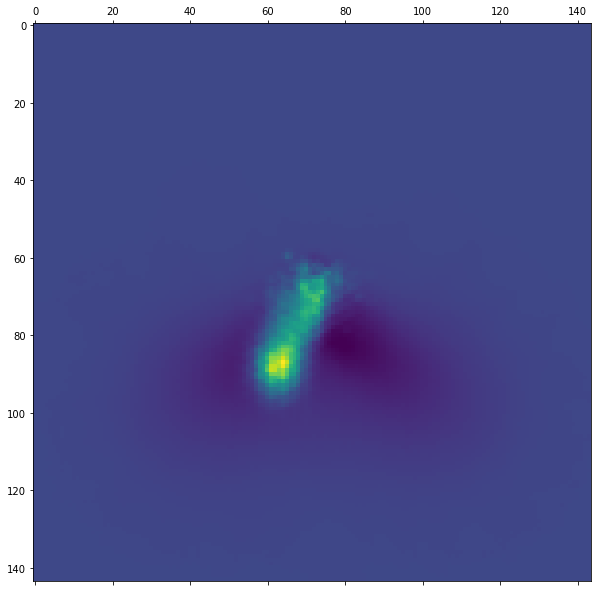

In [178]:
plt.figure(figsize=(10,10))
plt.matshow(data_norm[17],fignum=1)

In [164]:
BATCH_SIZE=100

In [165]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

In [166]:
X_train.astype('float64')


array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

In [167]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.4, random_state=42)

xtrain_tensor = torch.from_numpy(np.array(X_train.astype('float64'))) #converts numpy array to torch tensor
xtrain_sqz = xtrain_tensor.unsqueeze(1) #adds new dimension along axis 1
print(xtrain_sqz.shape)

ytrain_tensor = torch.from_numpy(np.array(y_train))
print(ytrain_tensor.shape)

xtest_tensor = torch.from_numpy(np.array(X_test.astype('float64'))) #converts numpy array to torch tensor
xtest_sqz = xtest_tensor.unsqueeze(1) #adds new dimension along axis 1
print(xtest_sqz.shape)

ytest_tensor = torch.from_numpy(np.array(y_test))
print(ytest_tensor.shape)

train_data = cd.CustomDataset(xtrain_sqz.float(), ytrain_tensor.float())
test_data = cd.CustomDataset(xtest_sqz.float(), ytest_tensor.float())

#defining dataloader class
train_loader = tud.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)

#same as above but for test data
test_loader = tud.DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=True)

torch.Size([4800, 1, 144, 144])
torch.Size([4800])
torch.Size([3200, 1, 144, 144])
torch.Size([3200])


In [168]:
class Model3(nn.Module):
    def __init__(self):
        super(Model3, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3)
        self.d1 = nn.Linear(142 * 142 * 8, 128)
        self.d2 = nn.Linear(128, 2)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)

        x = x.flatten(start_dim = 1)

        x = self.d1(x)
        x = F.relu(x)

        logits = self.d2(x)
        out = F.softmax(logits, dim=1)
        return out

In [169]:
def get_accuracy(logit, target, BATCH_SIZE):
    ''' Obtain accuracy for training round '''
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects/BATCH_SIZE
    return accuracy.item()

In [173]:
learning_rate = 0.000001
num_epochs = 10

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = Model3() 
model = model.to(device)
# criterion = nn.BCELoss()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [174]:
for epoch in range(num_epochs):
    train_running_loss = 0.0
    train_acc = 0.0

    model = model.train()

    ## training step
    for i, (images, labels) in enumerate(train_loader):

        labels=labels.type(torch.LongTensor)
        
        images = images.to(device)
        labels = labels.to(device)

        ## forward + backprop + loss
        logits = model(images)
        loss = criterion(logits, labels)
        optimizer.zero_grad()
        loss.backward()

        ## update model params
        optimizer.step()

        train_running_loss += loss.detach().item()
        train_acc += get_accuracy(logits, labels, BATCH_SIZE)
    
    model.eval()
    print('Epoch: %d | Loss: %.4f | Train Accuracy: %.2f' \
          %(epoch, train_running_loss / i, train_acc/i))     
    
    test_acc = 0.0
    for i, (images, labels) in enumerate(test_loader, 0):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        test_acc += get_accuracy(outputs, labels, BATCH_SIZE)
    
    print('Test Accuracy: %.2f'%( test_acc/i))

Epoch: 0 | Loss: 0.7019 | Train Accuracy: 63.89
Test Accuracy: 67.13
Epoch: 1 | Loss: 0.6537 | Train Accuracy: 68.72
Test Accuracy: 72.84
Epoch: 2 | Loss: 0.6445 | Train Accuracy: 69.55
Test Accuracy: 73.00
Epoch: 3 | Loss: 0.6056 | Train Accuracy: 73.51
Test Accuracy: 77.48
Epoch: 4 | Loss: 0.5823 | Train Accuracy: 75.87
Test Accuracy: 78.81
Epoch: 5 | Loss: 0.5774 | Train Accuracy: 76.32
Test Accuracy: 80.16
Epoch: 6 | Loss: 0.5798 | Train Accuracy: 76.11
Test Accuracy: 75.77
Epoch: 7 | Loss: 0.5907 | Train Accuracy: 75.00
Test Accuracy: 79.97
Epoch: 8 | Loss: 0.5763 | Train Accuracy: 76.43
Test Accuracy: 78.55
Epoch: 9 | Loss: 0.5576 | Train Accuracy: 78.34
Test Accuracy: 79.10


In [175]:
for i, (images, labels) in enumerate(train_loader):

        labels=labels.type(torch.LongTensor)
        
        images = images.to(device)
        labels = labels.to(device)
        
print(images.shape)
print(labels.shape)

torch.Size([100, 1, 144, 144])
torch.Size([100])


### Starting Again with Tensorflow

In [10]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.utils import shuffle

In [11]:
C130_dat, F170_dat = np.load('data/C_130keV_10000.npy'), np.load('data/F_170keV_10000.npy')

In [12]:
train_data, train_labels = [],[]
test_data, test_labels = [],[]
Csum, Fsum = [],[]

n_train = int(len(C130_dat) * 0.8)

for i in range(n_train):
    train_data.append(C130_dat[i])
    train_labels.append([1,0])
    Csum.append(np.sum(C130_dat[i]))

for i in range(n_train):
    train_data.append(F170_dat[i])
    train_labels.append([0,1])
    Fsum.append(np.sum(F170_dat[i]))

for i in range(n_train, len(C130_dat)):
    test_data.append(C130_dat[i])
    test_labels.append([1,0])
    Csum.append(np.sum(C130_dat[i]))

for i in range(n_train, len(F170_dat)):
    test_data.append(F170_dat[i])
    test_labels.append([0,1])
    Fsum.append(np.sum(F170_dat[i]))


# Maximum values

C130_max = np.amax(np.amax(C130_dat, axis=(1,2)))
F170_max = np.amax(np.amax(F170_dat, axis=(1,2)))
all_max = max(C130_max, F170_max)


# Normalise to (0,1)

train_data = np.array(train_data) / all_max
train_labels = np.array(train_labels)
test_data = np.array(test_data) / all_max
test_labels = np.array(test_labels)

# Shuffle Data

train_data, train_labels = shuffle(train_data, train_labels)
test_data, test_labels = shuffle(test_data, test_labels)

In [13]:
np.shape(test_labels)

(4000, 2)

We have 10,000 1s and 10,000 0s.

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, LeakyReLU, Dropout


def nr_model():
    nr_model = Sequential([
        Conv2D(8, kernel_size=(3,3), input_shape=(97,97,1)),
        LeakyReLU(alpha=0.01),
        MaxPooling2D(pool_size=(2, 2)),
        Dense(64),
        LeakyReLU(alpha=0.01),
        Dropout(0.1),
        Dense(2, activation='softmax')
    ], name='nr_model')
    return nr_model


model = nr_model()

In [15]:
model.summary()

Model: "nr_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 95, 95, 8)         80        
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 95, 95, 8)         0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 47, 47, 8)        0         
 )                                                               
                                                                 
 dense (Dense)               (None, 47, 47, 64)        576       
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 47, 47, 64)        0         
                                                                 
 dropout (Dropout)           (None, 47, 47, 64)        0         
                                                          

In [16]:
#loading the data into tf.data.Dataset objects
train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels)) 
test_dataset = tf.data.Dataset.from_tensor_slices((test_data, test_labels))
train_dataset.element_spec

#printing relevant properties
for inputs, labels in train_dataset.take(2):
    print(type(inputs))
    print(type(labels))
    print(inputs.shape)
    print(labels.shape)

<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
(97, 97)
(2,)
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
(97, 97)
(2,)


In [17]:
#batching the datasets
batch_size = 100
train_dataset = train_dataset.batch(batch_size)  # drop_remainder=True
test_dataset = test_dataset.batch(batch_size)

In [28]:
#compiling and fitting the model
sgd = tf.keras.optimizers.SGD(learning_rate=0.001)
loss_fn = tf.keras.losses.CategoricalCrossentropy()

model.compile(optimizer=sgd, loss=loss_fn, metrics=['accuracy'])
history = model.fit(train_dataset, epochs=40, validation_data=test_dataset)

Epoch 1/40
160/160 [==============================] - 6s 34ms/step - loss: 0.6931 - accuracy: 0.4994 - val_loss: 0.6930 - val_accuracy: 0.5153
Epoch 2/40
160/160 [==============================] - 5s 34ms/step - loss: 0.6931 - accuracy: 0.5032 - val_loss: 0.6930 - val_accuracy: 0.5203
Epoch 3/40
160/160 [==============================] - 5s 33ms/step - loss: 0.6931 - accuracy: 0.5111 - val_loss: 0.6929 - val_accuracy: 0.5265
Epoch 4/40
160/160 [==============================] - 5s 34ms/step - loss: 0.6930 - accuracy: 0.5147 - val_loss: 0.6929 - val_accuracy: 0.5290
Epoch 5/40
160/160 [==============================] - 5s 34ms/step - loss: 0.6930 - accuracy: 0.5156 - val_loss: 0.6928 - val_accuracy: 0.5368
Epoch 6/40
160/160 [==============================] - 5s 34ms/step - loss: 0.6929 - accuracy: 0.5209 - val_loss: 0.6928 - val_accuracy: 0.5372
Epoch 7/40
160/160 [==============================] - 5s 34ms/step - loss: 0.6929 - accuracy: 0.5244 - val_loss: 0.6928 - val_accuracy: 0.5447

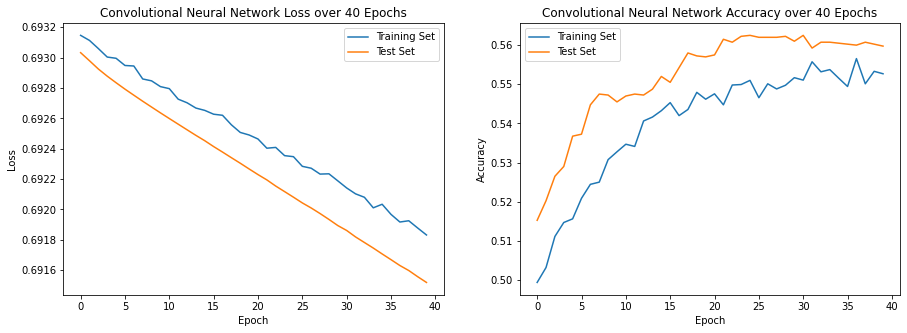

In [29]:
#plotting loss function and accuracy for training and test sets over all epochs
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))
ax1.plot(history.history['loss']),ax1.plot(history.history['val_loss'])
ax1.set_title('Convolutional Neural Network Loss over 40 Epochs')
ax1.set_ylabel('Loss'),ax1.set_xlabel('Epoch'),ax1.legend(['Training Set', 'Test Set'], loc='best');
ax2.plot(history.history['accuracy']),ax2.plot(history.history['val_accuracy'])
ax2.set_title('Convolutional Neural Network Accuracy over 40 Epochs')
ax2.set_ylabel('Accuracy'),ax2.set_xlabel('Epoch'),ax2.legend(['Training Set', 'Test Set'], loc='best');

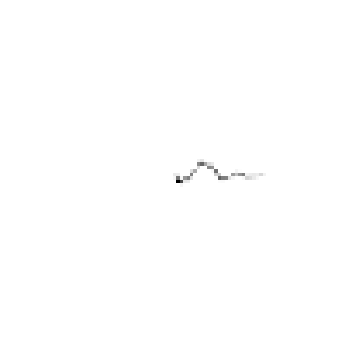

In [20]:
image = train_data[43]

#initial plotting of chosen image
plt.figure(figsize=(6, 10))
plt.imshow(image,cmap='Greys')
plt.axis('off')
plt.show()

In [33]:
from tensorflow.keras.models import Model

#Model and model are different
#getting model inputs, layer names, outputs for visualisation
inputs = model.inputs
layer_names = [layer.name for layer in model.layers]
outputs = [model.get_layer(layer_name).output for layer_name in layer_names]
#creating model for extracting features
model_features = Model(inputs=inputs, outputs=outputs)

In [34]:
#re-shaping image and passing through new model to output features
input = image.reshape((1,) + image.shape)
features = model_features.predict(input)

In [35]:
conv_features = features[0], features[1], features[2]

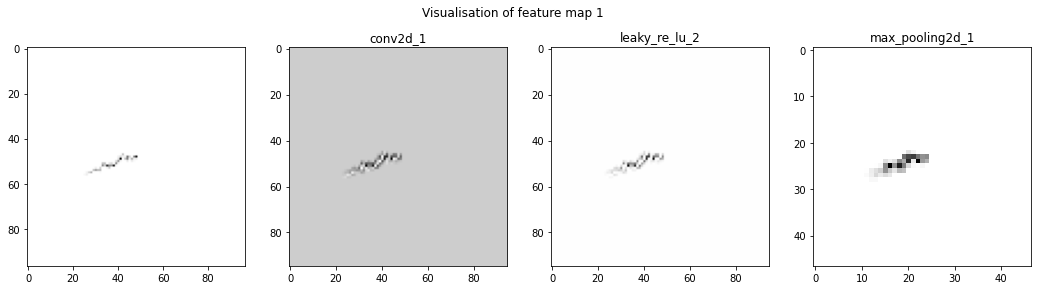

In [36]:
#plotting features from convolutional layers, along with layer names
fig, axs = plt.subplots(1,4, figsize=(18,5))
fig.subplots_adjust(top=1)
fig.suptitle('Visualisation of feature map 1')
axs[0].imshow(image, cmap='Greys',label='input')
for i in range(len(conv_features)):
    feature_map = conv_features[i]
    axs[i+1].imshow(feature_map[0, ..., 1],cmap='Greys')
    axs[i+1].set_title(layer_names[i]);

In [37]:
np.set_printoptions(threshold=sys.maxsize)
print(model.layers[0].weights)
print(model.layers[0].bias.numpy())
print(model.layers[0].bias_initializer)

[<tf.Variable 'conv2d_1/kernel:0' shape=(3, 3, 1, 8) dtype=float32, numpy=
array([[[[ 0.16254964,  0.15607193, -0.20891304, -0.2101709 ,
           0.10218885,  0.18087499, -0.18284321, -0.251383  ]],

        [[-0.00131685,  0.11234825, -0.11145911,  0.09347166,
           0.00777845,  0.2539248 ,  0.2088335 , -0.2450382 ]],

        [[ 0.16572714, -0.25279966,  0.2205106 ,  0.04625662,
           0.22975236,  0.1854643 ,  0.23106189, -0.2681691 ]]],


       [[[-0.24099526,  0.2310601 ,  0.2102369 , -0.1808897 ,
          -0.02376275, -0.02189747,  0.19055893, -0.06972846]],

        [[-0.07351637, -0.16723125,  0.25073722, -0.15147683,
           0.01143335,  0.11856727,  0.20271437, -0.08241521]],

        [[-0.049428  ,  0.2690495 ,  0.2221936 ,  0.05346889,
          -0.22865504, -0.01581039,  0.0508078 ,  0.22336799]]],


       [[[-0.05865597,  0.12216119,  0.18103231,  0.05617342,
           0.24522966,  0.2625602 ,  0.12354214, -0.22244392]],

        [[ 0.15885623, -0.101819

In [18]:
slice_val = 25
b = image[slice_val:-slice_val, slice_val:-slice_val]

NameError: name 'image' is not defined

In [19]:
plt.figure(figsize=(6, 10))
plt.imshow(b,cmap='Greys')
plt.axis('off')
plt.show()
plt.figure(figsize=(6, 10))
plt.imshow(image,cmap='Greys')
plt.axis('off')
plt.show()

NameError: name 'b' is not defined

<Figure size 432x720 with 0 Axes>

In [21]:
slice_val=25

train_data_sliced = [train_data[i][slice_val:-slice_val, slice_val:-slice_val] for i in range(len(train_data))]
test_data_sliced = [test_data[i][slice_val:-slice_val, slice_val:-slice_val] for i in range(len(test_data))]

In [22]:
np.shape(train_data_sliced)

(16000, 47, 47)

In [23]:
np.shape(test_data_sliced)

(4000, 47, 47)

In [24]:
#loading the data into tf.data.Dataset objects
train_dataset_sliced = tf.data.Dataset.from_tensor_slices((train_data_sliced, train_labels)) 
test_dataset_sliced = tf.data.Dataset.from_tensor_slices((test_data_sliced, test_labels))
train_dataset.element_spec

(TensorSpec(shape=(None, 97, 97), dtype=tf.float64, name=None),
 TensorSpec(shape=(None, 2), dtype=tf.int64, name=None))

In [25]:
#batching the datasets
batch_size = 32
train_dataset_sliced = train_dataset_sliced.batch(batch_size)  # drop_remainder=True
test_dataset_sliced = test_dataset_sliced.batch(batch_size)

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, LeakyReLU, Dropout


def nr_model():
    nr_model = Sequential([
        Conv2D(1, kernel_size=(3,3), input_shape=(47,47,1)),
        Flatten(),
        Dense(1024, activation='relu'),
        Dense(2, activation='softmax')
    ], name='nr_model')
    return nr_model


model = nr_model()

In [27]:
#compiling and fitting the model
sgd = tf.keras.optimizers.SGD(learning_rate=0.01)
loss_fn = tf.keras.losses.CategoricalCrossentropy()

model.compile(optimizer=sgd, loss=loss_fn, metrics=['accuracy'])
history = model.fit(train_dataset_sliced, epochs=400, validation_data=test_dataset_sliced)

Epoch 1/400
500/500 [==============================] - 4s 8ms/step - loss: 0.6928 - accuracy: 0.5135 - val_loss: 0.6921 - val_accuracy: 0.5330
Epoch 2/400
500/500 [==============================] - 4s 8ms/step - loss: 0.6917 - accuracy: 0.5353 - val_loss: 0.6910 - val_accuracy: 0.5535
Epoch 3/400
500/500 [==============================] - 4s 8ms/step - loss: 0.6907 - accuracy: 0.5457 - val_loss: 0.6899 - val_accuracy: 0.5577
Epoch 4/400
500/500 [==============================] - 4s 8ms/step - loss: 0.6897 - accuracy: 0.5518 - val_loss: 0.6889 - val_accuracy: 0.5623
Epoch 5/400
500/500 [==============================] - 4s 8ms/step - loss: 0.6888 - accuracy: 0.5546 - val_loss: 0.6879 - val_accuracy: 0.5640
Epoch 6/400
500/500 [==============================] - 4s 8ms/step - loss: 0.6879 - accuracy: 0.5549 - val_loss: 0.6869 - val_accuracy: 0.5663
Epoch 7/400
500/500 [==============================] - 4s 8ms/step - loss: 0.6870 - accuracy: 0.5553 - val_loss: 0.6859 - val_accuracy: 0.5648

KeyboardInterrupt: 

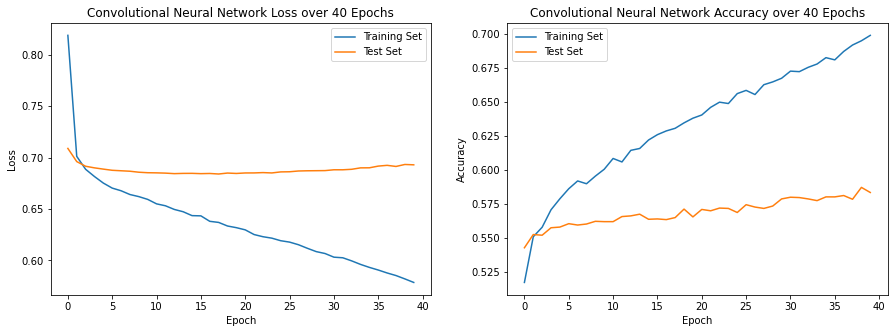

In [97]:
#plotting loss function and accuracy for training and test sets over all epochs
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))
ax1.plot(history.history['loss']),ax1.plot(history.history['val_loss'])
ax1.set_title('Convolutional Neural Network Loss over 40 Epochs')
ax1.set_ylabel('Loss'),ax1.set_xlabel('Epoch'),ax1.legend(['Training Set', 'Test Set'], loc='best');
ax2.plot(history.history['accuracy']),ax2.plot(history.history['val_accuracy'])
ax2.set_title('Convolutional Neural Network Accuracy over 40 Epochs')
ax2.set_ylabel('Accuracy'),ax2.set_xlabel('Epoch'),ax2.legend(['Training Set', 'Test Set'], loc='best');

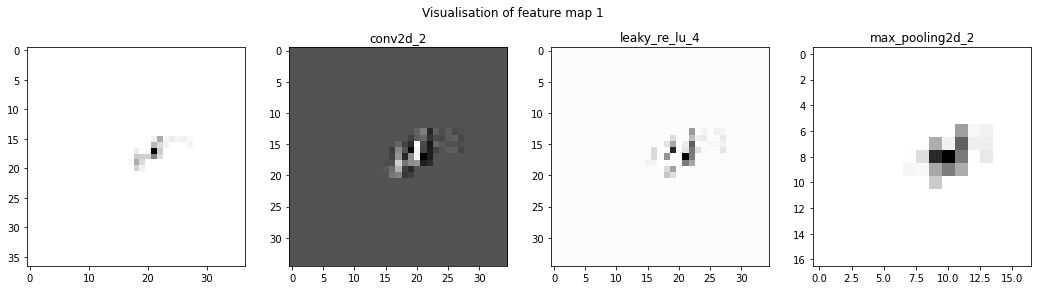

In [91]:
image = x_train_sliced[20]

#Model and model are different
#getting model inputs, layer names, outputs for visualisation
inputs = model.inputs
layer_names = [layer.name for layer in model.layers]
outputs = [model.get_layer(layer_name).output for layer_name in layer_names]
#creating model for extracting features
model_features = Model(inputs=inputs, outputs=outputs)

#re-shaping image and passing through new model to output features
input = image.reshape((1,) + image.shape)
features = model_features.predict(input)

conv_features = features[0], features[1], features[2]

#plotting features from convolutional layers, along with layer names
fig, axs = plt.subplots(1,4, figsize=(18,5))
fig.subplots_adjust(top=1)
fig.suptitle('Visualisation of feature map 1')
axs[0].imshow(image, cmap='Greys',label='input')
for i in range(len(conv_features)):
    feature_map = conv_features[i]
    axs[i+1].imshow(feature_map[0, ..., 1],cmap='Greys')
    axs[i+1].set_title(layer_names[i]);

### Linear Model

In [38]:
#loading the data into tf.data.Dataset objects
train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels)) 
test_dataset = tf.data.Dataset.from_tensor_slices((test_data, test_labels))
train_dataset.element_spec

#printing relevant properties
for inputs, labels in train_dataset.take(2):
    print(type(inputs))
    print(type(labels))
    print(inputs.shape)
    print(labels.shape)

<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
(97, 97)
(2,)
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
(97, 97)
(2,)


In [39]:
#batching the datasets
batch_size = 32
train_dataset = train_dataset.batch(batch_size)  # drop_remainder=True
test_dataset = test_dataset.batch(batch_size)

In [50]:
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, LeakyReLU, Dropout

def lin_model():
    lin_model = Sequential([
        Flatten(input_shape=(97,97,1)),
        Dense(2, activation='softmax')
    ], name='lin_model')
    return lin_model

model = lin_model()

In [51]:
model.summary()

Model: "lin_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_7 (Flatten)         (None, 9409)              0         
                                                                 
 dense_10 (Dense)            (None, 2)                 18820     
                                                                 
Total params: 18,820
Trainable params: 18,820
Non-trainable params: 0
_________________________________________________________________


In [52]:
#compiling and fitting the model
opt = tf.keras.optimizers.Adam(learning_rate=0.01)
loss_fn = tf.keras.losses.CategoricalCrossentropy()

model.compile(optimizer=opt, loss=loss_fn, metrics=['accuracy'])
history = model.fit(train_dataset, epochs=500, validation_data=test_dataset)

Epoch 1/500
500/500 [==============================] - 2s 4ms/step - loss: 0.6827 - accuracy: 0.5585 - val_loss: 0.6744 - val_accuracy: 0.5800
Epoch 2/500
500/500 [==============================] - 2s 3ms/step - loss: 0.6678 - accuracy: 0.5889 - val_loss: 0.6730 - val_accuracy: 0.5872
Epoch 3/500
500/500 [==============================] - 2s 3ms/step - loss: 0.6593 - accuracy: 0.5998 - val_loss: 0.6722 - val_accuracy: 0.5890
Epoch 4/500
500/500 [==============================] - 2s 3ms/step - loss: 0.6530 - accuracy: 0.6081 - val_loss: 0.6714 - val_accuracy: 0.5940
Epoch 5/500
500/500 [==============================] - 2s 3ms/step - loss: 0.6480 - accuracy: 0.6137 - val_loss: 0.6706 - val_accuracy: 0.5943
Epoch 6/500
500/500 [==============================] - 2s 3ms/step - loss: 0.6437 - accuracy: 0.6187 - val_loss: 0.6699 - val_accuracy: 0.5962
Epoch 7/500
500/500 [==============================] - 2s 3ms/step - loss: 0.6400 - accuracy: 0.6214 - val_loss: 0.6692 - val_accuracy: 0.5970

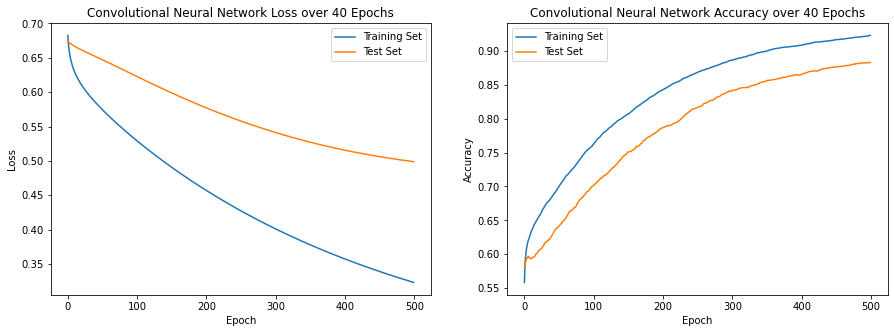

In [53]:
#plotting loss function and accuracy for training and test sets over all epochs
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))
ax1.plot(history.history['loss']),ax1.plot(history.history['val_loss'])
ax1.set_title('Convolutional Neural Network Loss over 40 Epochs')
ax1.set_ylabel('Loss'),ax1.set_xlabel('Epoch'),ax1.legend(['Training Set', 'Test Set'], loc='best');
ax2.plot(history.history['accuracy']),ax2.plot(history.history['val_accuracy'])
ax2.set_title('Convolutional Neural Network Accuracy over 40 Epochs')
ax2.set_ylabel('Accuracy'),ax2.set_xlabel('Epoch'),ax2.legend(['Training Set', 'Test Set'], loc='best');

In [55]:
print(model.layers[1].weights)
print(model.layers[1].bias.numpy())
print(model.layers[1].bias_initializer)

[<tf.Variable 'dense_10/kernel:0' shape=(9409, 2) dtype=float32, numpy=
array([[-2.10773442e-02,  1.56791639e-02],
       [-6.89334795e-03,  8.75982083e-03],
       [ 3.08261067e-03, -7.46139139e-03],
       [-2.35120505e-02, -1.04199536e-02],
       [ 1.28128286e-02, -1.95303932e-03],
       [ 2.22068671e-02,  2.23064050e-03],
       [ 2.97768787e-03, -2.49861665e-02],
       [ 7.71858357e-03,  2.49000918e-02],
       [-1.38199944e-02,  1.20799076e-02],
       [ 2.22349744e-02, -8.65348801e-03],
       [-2.29688026e-02, -1.82327218e-02],
       [-5.37278876e-03, -7.03701004e-03],
       [-2.51939949e-02,  2.05524769e-02],
       [ 1.77374128e-02, -1.17737362e-02],
       [-2.27719732e-02,  1.27547588e-02],
       [ 3.56573611e-03, -2.15872824e-02],
       [-2.51292493e-02,  2.99437530e-03],
       [ 2.67795660e-03,  8.13703798e-03],
       [-1.10159656e-02, -1.36227533e-03],
       [-7.08604231e-04, -4.87422198e-03],
       [ 9.38559882e-03, -1.40288109e-02],
       [-4.91574220e-03, 

In [71]:
weights_arr = model.layers[1].weights[0]

In [75]:
weights_array = weights_arr.numpy()

In [77]:
weights_array.shape

(9409, 2)

In [81]:
print(np.max(weights_array[0]))
print(np.min(weights_array[0]))
print(np.mean(weights_array[0]))
print(np.std(weights_array[0]))

0.015679164
-0.021077344
-0.0026990902
0.018378254


Low standard deviation, as we would expect.

### Now trying CNN again with dropout to prevent overfitting

In [ ]:
#loading the data into tf.data.Dataset objects
train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels)) 
test_dataset = tf.data.Dataset.from_tensor_slices((test_data, test_labels))
train_dataset.element_spec

#printing relevant properties
for inputs, labels in train_dataset.take(2):
    print(type(inputs))
    print(type(labels))
    print(inputs.shape)
    print(labels.shape)

In [ ]:
#batching the datasets
batch_size = 32
train_dataset = train_dataset.batch(batch_size)  # drop_remainder=True
test_dataset = test_dataset.batch(batch_size)

In [98]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, LeakyReLU, Dropout


def nr_model():
    nr_model = Sequential([
        Conv2D(1, kernel_size=(3,3), padding='SAME', input_shape=(97,97,1)),
        Flatten(),
        Dense(1024, activation='relu'),
        Dense(2, activation='softmax')
    ], name='nr_model')
    return nr_model


model = nr_model()

In [99]:
#compiling and fitting the model
opt = tf.keras.optimizers.Adam(learning_rate=0.01)
loss_fn = tf.keras.losses.CategoricalCrossentropy()

model.compile(optimizer=opt, loss=loss_fn, metrics=['accuracy'])
history = model.fit(train_dataset, epochs=500, validation_data=test_dataset)

Epoch 1/500
500/500 [==============================] - 11s 21ms/step - loss: 0.7280 - accuracy: 0.5477 - val_loss: 0.6951 - val_accuracy: 0.5502
Epoch 2/500
500/500 [==============================] - 10s 21ms/step - loss: 0.6949 - accuracy: 0.5033 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 3/500
500/500 [==============================] - 10s 21ms/step - loss: 0.6936 - accuracy: 0.4997 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 4/500
500/500 [==============================] - 10s 21ms/step - loss: 0.6937 - accuracy: 0.5010 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 5/500
241/500 [=============>................] - ETA: 4s - loss: 0.6937 - accuracy: 0.4992

KeyboardInterrupt: 

## Setting Intensities as Equal

In [164]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.utils import shuffle

In [165]:
C130_dat, F170_dat = np.load('data_old/C_130keV_10000.npy'), np.load('data_old/F_170keV_10000.npy')

In [166]:
C130_dat -= np.mean(C130_dat) # the -= means can be read as x = x- np.mean(x)
C130_dat/=np.std(C130_dat)

F170_dat -= np.mean(F170_dat) # the -= means can be read as x = x- np.mean(x)
F170_dat/=np.std(F170_dat)

In [167]:
train_data, train_labels = [],[]
test_data, test_labels = [],[]
Csum, Fsum = [],[]

n_train = int(len(C130_dat) * 0.8)

for i in range(n_train):
    train_data.append(C130_dat[i])
    train_labels.append([1,0])
    Csum.append(np.sum(C130_dat[i]))

for i in range(n_train):
    train_data.append(F170_dat[i])
    train_labels.append([0,1])
    Fsum.append(np.sum(F170_dat[i]))

for i in range(n_train, len(C130_dat)):
    test_data.append(C130_dat[i])
    test_labels.append([1,0])
    Csum.append(np.sum(C130_dat[i]))

for i in range(n_train, len(F170_dat)):
    test_data.append(F170_dat[i])
    test_labels.append([0,1])
    Fsum.append(np.sum(F170_dat[i]))


# Maximum values

C130_max = np.amax(np.amax(C130_dat, axis=(1,2)))
F170_max = np.amax(np.amax(F170_dat, axis=(1,2)))
all_max = max(C130_max, F170_max)


# Normalise to (0,1)

train_data = np.array(train_data) / all_max
train_labels = np.array(train_labels)
test_data = np.array(test_data) / all_max
test_labels = np.array(test_labels)

# Shuffle Data

train_data, train_labels = shuffle(train_data, train_labels)
test_data, test_labels = shuffle(test_data, test_labels)


Accuracy Possible with Cut of 0 on Total Intensity: 51.345%


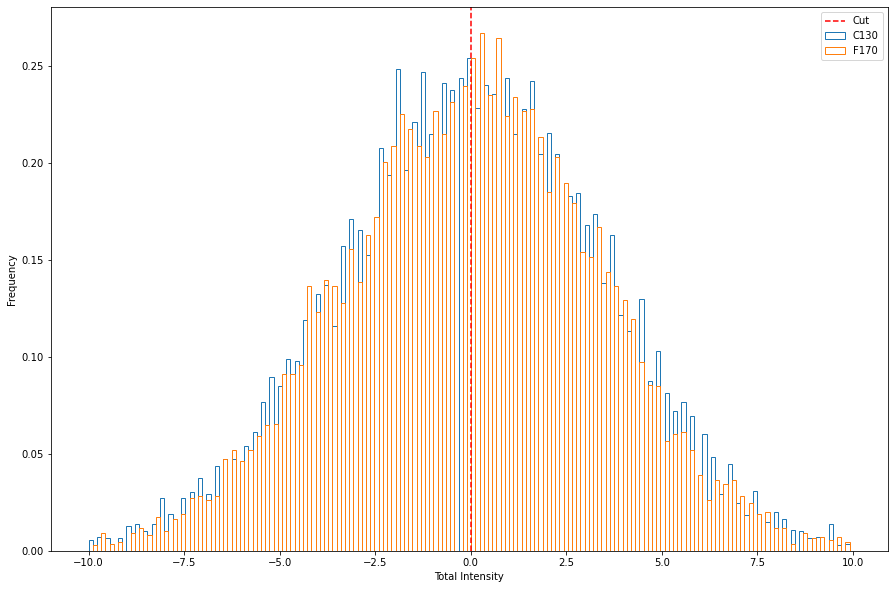

In [168]:
cut = 0
Cless, Fgrt = [],[]
for i in range(len(Fsum)):
    if Fsum[i] > cut:
        Fgrt.append(Fsum[i])
    if Csum[i] <= cut:
        Cless.append(Csum[i])

plt.figure(figsize=(15,10))
plt.hist(Csum, density=True, histtype='step', bins=np.arange(-10,10,0.11), label='C130')  # density=False would make counts
plt.hist(Fsum, density=True, histtype='step', bins=np.arange(-10,10,0.11), label='F170')
plt.axvline(cut, c='r', ls='--', label='Cut')
plt.ylabel('Frequency')
plt.xlabel('Total Intensity')
plt.legend()
plt.savefig('intensity_hist.png')

Acc = (len(Fgrt)+len(Cless))/(len(Fsum)+len(Csum))*100
print('\nAccuracy Possible with Cut of {} on Total Intensity: {}%'.format(cut,Acc))

In [208]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, LeakyReLU, Dropout


def nr_model():
    nr_model = Sequential([
        Conv2D(8, kernel_size=(3,3), input_shape=(97,97,1)),
        LeakyReLU(alpha=0.01),
        Conv2D(8, kernel_size=(3,3)),
        LeakyReLU(alpha=0.01),
        Flatten(),
        Dense(2, activation='softmax')
    ], name='nr_model')
    return nr_model


model = nr_model()

In [209]:
np.shape(test_labels)

(4000, 2)

In [210]:
np.shape(train_labels)

(16000, 2)

In [211]:
np.shape(train_data)

(16000, 97, 97)

In [212]:
model.summary()

Model: "nr_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_70 (Conv2D)          (None, 95, 95, 8)         80        
                                                                 
 leaky_re_lu_85 (LeakyReLU)  (None, 95, 95, 8)         0         
                                                                 
 conv2d_71 (Conv2D)          (None, 93, 93, 8)         584       
                                                                 
 leaky_re_lu_86 (LeakyReLU)  (None, 93, 93, 8)         0         
                                                                 
 flatten_22 (Flatten)        (None, 69192)             0         
                                                                 
 dense_49 (Dense)            (None, 2)                 138386    
                                                                 
Total params: 139,050
Trainable params: 139,050
Non-traina

In [213]:
#loading the data into tf.data.Dataset objects
train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels)) 
test_dataset = tf.data.Dataset.from_tensor_slices((test_data, test_labels))
train_dataset.element_spec

#printing relevant properties
for inputs, labels in train_dataset.take(2):
    print(type(inputs))
    print(type(labels))
    print(inputs.shape)
    print(labels.shape)

<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
(97, 97)
(2,)
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
(97, 97)
(2,)


In [214]:
#batching the datasets
batch_size = 50
train_dataset = train_dataset.batch(batch_size)  # drop_remainder=True
test_dataset = test_dataset.batch(batch_size)

In [215]:
#compiling and fitting the model
sgd = tf.keras.optimizers.Adam(learning_rate=0.001)
loss_fn = tf.keras.losses.CategoricalCrossentropy()

model.compile(optimizer=sgd, loss=loss_fn, metrics=['accuracy'])
history = model.fit(train_dataset, epochs=200, validation_data=test_dataset)

Epoch 1/200
320/320 [==============================] - 11s 34ms/step - loss: 0.6860 - accuracy: 0.5502 - val_loss: 0.6803 - val_accuracy: 0.5740
Epoch 2/200
320/320 [==============================] - 11s 34ms/step - loss: 0.6777 - accuracy: 0.5737 - val_loss: 0.6724 - val_accuracy: 0.5830
Epoch 3/200
320/320 [==============================] - 11s 34ms/step - loss: 0.6657 - accuracy: 0.5923 - val_loss: 0.6644 - val_accuracy: 0.6008
Epoch 4/200
320/320 [==============================] - 11s 34ms/step - loss: 0.6509 - accuracy: 0.6165 - val_loss: 0.6563 - val_accuracy: 0.6118
Epoch 5/200
320/320 [==============================] - 11s 34ms/step - loss: 0.6358 - accuracy: 0.6319 - val_loss: 0.6471 - val_accuracy: 0.6225
Epoch 6/200
320/320 [==============================] - 11s 34ms/step - loss: 0.6234 - accuracy: 0.6470 - val_loss: 0.6424 - val_accuracy: 0.6277
Epoch 7/200
320/320 [==============================] - 11s 34ms/step - loss: 0.6109 - accuracy: 0.6601 - val_loss: 0.6354 - val_ac

KeyboardInterrupt: 

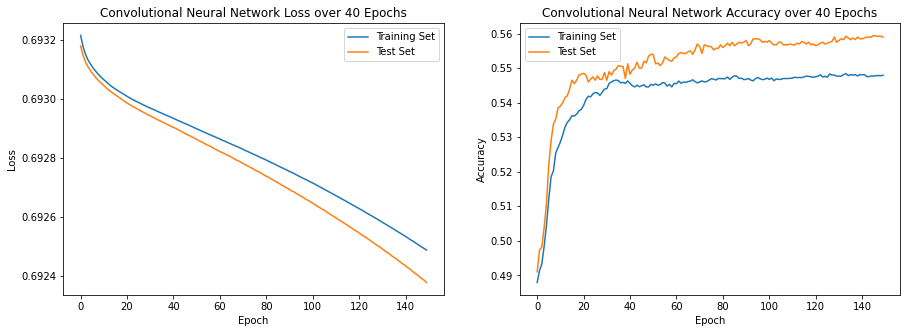

In [138]:
#plotting loss function and accuracy for training and test sets over all epochs
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))
ax1.plot(history.history['loss']),ax1.plot(history.history['val_loss'])
ax1.set_title('Convolutional Neural Network Loss over 40 Epochs')
ax1.set_ylabel('Loss'),ax1.set_xlabel('Epoch'),ax1.legend(['Training Set', 'Test Set'], loc='best');
ax2.plot(history.history['accuracy']),ax2.plot(history.history['val_accuracy'])
ax2.set_title('Convolutional Neural Network Accuracy over 40 Epochs')
ax2.set_ylabel('Accuracy'),ax2.set_xlabel('Epoch'),ax2.legend(['Training Set', 'Test Set'], loc='best');